In [8]:
#General dataframe
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as scistat
from datetime import datetime

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#ScipyStats
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import TimeSeriesSplit

import random
random.seed(200)

np.random.seed(200)

import os
import pickle

#### Establish Test Parameters
y_val = target variable for the study

stock_x_cols = feature variables to include if you are adding cross-sectional stock features

start_date = starting date for data

re_train_dates = a list of dates for which to train the model

test_length_years = # of years to test the model

CV_length_years = # of years to cross-validate the model

In [9]:
#Insert parameters here 
target = ['1m_fwd_ret']
stock_x_cols = ['mvel1', 'beta', 'bm', 'operprof', 'agr', 'sic2'] 
upload_cols = ['DATE', 'permno', 'mvel1', 'beta', 'bm', 'operprof', 'agr', 'sic2']
start = '1969-12-31'
re_train_dates = [pd.to_datetime('2003-12-31')]
test_length_years = 19
CV_length_years = 10


#### Upload the processed data from File #1

In [10]:
mylist = []
filename = 'C:/Users/andrew_lazzeri/Desktop/Project_Files/Data Upload/final_cross_section_df.csv'
df_test = pd.read_csv(filename, nrows = 1)
col_conv = {c: np.float32 for c in df_test.columns}
del df_test 

for chunk in  pd.read_csv(filename, sep=',', usecols=upload_cols, chunksize=5000, error_bad_lines = False, engine='python'):
    mylist.append(chunk)

security_df = pd.concat(mylist, axis= 0)
del mylist

#security_df = security_df.set_index(['DATE', 'permno'])
security_df['DATE'] = pd.to_datetime(security_df['DATE'].str[-8::]) +  pd.offsets.MonthEnd()
security_df = security_df.set_index(['DATE', 'permno'])
security_df = security_df.astype(np.float32)
security_df['sic2'] = security_df['sic2'].astype('category')
security_df = security_df[security_df.index.get_level_values('DATE')>=start]

#Upload the macro dataframe 
macro_path = "C:/Users/andrew_lazzeri/Desktop/Project_Files/Data Upload/Macroeconomic_Training_Data.csv"
macro_df = pd.read_csv(macro_path)
macro_df['Dates'] = pd.to_datetime(macro_df['Dates']) + pd.offsets.MonthEnd()
macro_df = macro_df.set_index('Dates')
macro_df.index.name = 'date'

#Upload the return df
return_df = pd.read_csv("C:/Users/andrew_lazzeri/Desktop/Project_Files/Data Upload/return dfs/append_df.csv")
return_df = return_df[['permno', 'date', target[0]]]
return_df['date'] = pd.to_datetime(return_df['date']) + pd.offsets.MonthEnd()
return_df.columns = ['permno', 'DATE', target[0]]
return_df = return_df.set_index(['DATE', 'permno'])
return_df = return_df[return_df.index.get_level_values('DATE')>=start]

#Setup the return df
#return_df = return_df.reset_index().set_index(['DATE', 'permno'])
security_df = security_df.join(return_df)
security_df.index = security_df.index.set_names(['date', 'permno'])
security_df = security_df.reset_index()
security_df = security_df.drop_duplicates(subset=['date', 'permno'])
security_df = security_df.set_index(['date', 'permno'])
security_df['sic2'] = security_df['sic2'].astype(float)

In [68]:
macro_df.shape

(626, 112)

In [11]:
#security_df[target[0]] = security_df.groupby(security_df.index.get_level_values('date')).rank(ascending = True, pct=True)['1m_fwd_ret']

In [12]:
#Setup the sic2 aggregates
security_df['sic_agg'] = np.nan
security_df['sic_agg'] = np.where(security_df['sic2'] < 10, 'Ag, Forest & Fishing', security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 10) & ((security_df['sic2'] < 15)), 
                                 'Mining',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 15) & ((security_df['sic2'] < 18)), 
                                 'Construction',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 20) & ((security_df['sic2'] < 40)), 
                                 'Manufacturing',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 40) & ((security_df['sic2'] < 50)), 
                                 'Transportation, Comm, Etc.',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 50) & ((security_df['sic2'] < 52)), 
                                 'Wholesale Trade',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 52) & ((security_df['sic2'] < 60)), 
                                 'Retail Trade',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 60) & ((security_df['sic2'] < 68)), 
                                 'Finance, Insurance, Real Estate',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 70) & ((security_df['sic2'] < 90)), 
                                 'Services',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 91) & ((security_df['sic2'] < 97)), 
                                 'Public Admin',security_df['sic_agg'])
security_df['sic_agg'] = np.where(security_df['sic_agg'] == 'nan', 'Unknown', security_df['sic_agg'])
security_df['sic_agg'].value_counts(normalize=True)
#security_df['sic2'] = security_df['sic2'].astype("category")
security_df = security_df.drop(['sic2'], axis=1)

In [69]:
security_df['sic_agg'].value_counts()

Manufacturing                      980630
Finance, Insurance, Real Estate    668352
Services                           339863
Transportation, Comm, Etc.         223529
Unknown                            177927
Retail Trade                       144953
Mining                             140092
Wholesale Trade                     83544
Construction                        28806
Ag, Forest & Fishing                 8082
Name: sic_agg, dtype: int64

In [14]:
### The below function data is for cleaning and pre-processing the dataframe 
#Packages
from pandas.tseries.offsets import DateOffset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

#Convert various forms of issue rows into nans and drop with parameters to drop rows and columns based on specific thresholds
def drop_nasties(df, row_perc: float, col_perc: float, remove_duplicates = True):
    """
    Takes in a dataframe and: 
    -replaces infinities with nans for processing
    -drops rows with certain missing value percentages
    -drops columns with certain missing value percentages
    -keeps the first entry of a completely duplicated column
    """
    
    rows, cols = df.shape
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis = 0, thresh = int(row_perc*cols), inplace=True)
    df.dropna(axis = 1, thresh = int(col_perc*rows), inplace=True)
    df.drop_duplicates(keep='first', inplace=remove_duplicates)
    return df

#One hot encode categorical columns, drop the original categorical columns and rejoin the one hot encoded columns to OG dataframe
def one_hot_encode(df, cat_cols):
    """
    One hot encode the categorical variables.  
    Here that would be the SIC codes
    """
    
    dummy_df = pd.get_dummies(df[cat_cols])
    return_df  =  df.join(dummy_df, how = 'left')
    return_df.drop(cat_cols, axis = 1, inplace = True)
    return  return_df

#Split the dataframe axis along the date axis and divide the data into training, CV and test periods
#The period inputs here represent the number of years to include in each period and will be X years back from the current date
def time_split(df, current_date, CV_length_years, test_length_years):
    
    """
    Split the data into train, CV and test sets based on time
    -Training ends 15 years prior to the current date
    -CV ends 5 years prior to the current date
    """
    current_date = current_date + pd.DateOffset(months=0)
    test_end_date = current_date + DateOffset(years = test_length_years)
    train_end_date = current_date - DateOffset(years = CV_length_years) 
    CV_end_date = current_date 
    
    #Split dataframes into train, CV, test
    train_df = df[df.index.get_level_values('date') <= train_end_date]
    CV_df = df[(df.index.get_level_values('date') > train_end_date) & (df.index.get_level_values('date') <= current_date)]
    test_df = df[(df.index.get_level_values('date') > current_date) & (df.index.get_level_values('date') <= test_end_date)]
      
    return train_df, CV_df, test_df

#Identify columns with missing target variables.  While I impute some values a missing target is dropable
def missing_y_vars(train_df, CV_df, test_df, target):
    """
    Drops x feature variabes when the y variable is missing (no fwd return)
    Note, this will vary based on the target variable 
    """
    train_df = train_df.dropna(subset=target)  
    CV_df = CV_df.dropna(subset=target) 
    test_df = test_df.dropna(subset=target) 
    return train_df, CV_df, test_df 

#Seperates the dataframes into X and Y variables
def separate_y_variables(train_df, CV_df, test_df, y_cols):
    """
    Split out y variables in the train, CV and test set
    """
    
    #Gather y variables
    train_y = train_df[y_cols]
    CV_df_y = CV_df[y_cols]
    test_df_y = test_df[y_cols]
    #Remove y variables
    train_x = train_df.drop(y_cols, axis = 1)
    CV_df_x = CV_df.drop(y_cols, axis = 1)
    test_df_x = test_df.drop(y_cols, axis=1)
    return  train_y, train_x, CV_df_y, CV_df_x, test_df_y, test_df_x

#Splits out numerical dataframes for further manipulation
def numerical_dfs(train_df, CV_df, test_df, numerical_cols):
    """
    Seperate numerical columns for train, CV and test data
    """
    
    train_scaled = train_df[numerical_cols]
    CV_scaled = CV_df[numerical_cols]
    test_scaled = test_df[numerical_cols]
    return train_scaled, CV_scaled, test_scaled

#Winsorize each dataframe cross sectionally based on percentile values for a specific date index
def winsorize(train_y, train_x, CV_y, CV_x, test_y, test_x, lower_lim, upper_lim):
    from scipy.stats import mstats
    
    """
    Winsorize each data set based on the month's observations
    lower_lim / upper_lim serve as the percentile bounds for the wisorization
    """

    def winsorize_series(x):
        return mstats.winsorize(x, limits=[lower_lim,upper_lim])

    #Apply to all the dataframes
    train_y = train_y.groupby(train_y.index.get_level_values('date')).transform(winsorize_series)
    train_x = train_x.groupby(train_x.index.get_level_values('date')).transform(winsorize_series)
    CV_y = CV_y.groupby(CV_y.index.get_level_values('date')).transform(winsorize_series)
    CV_x = CV_x.groupby(CV_x.index.get_level_values('date')).transform(winsorize_series)
    test_y = test_y.groupby(test_y.index.get_level_values('date')).transform(winsorize_series)
    test_x = test_x.groupby(test_x.index.get_level_values('date')).transform(winsorize_series)
    return train_y, train_x, CV_y, CV_x, test_y, test_x

#Min max scale cross sectionally based on a specific date
def min_max_scaler(train_df, CV_df, test_df):
    
    """
    Takes in the train, CV and test df and applies a simple min max scaler
    The scaler is based on grouped values by date to avoid look ahead bias 
    In effect this performs a cross sectional min max scale at each date
    """

    def min_max_transformer(x):
        return (x - x.min())/(x.max() - x.min())

    train_df = pd.DataFrame(train_df.groupby(train_df.index.get_level_values('date')).transform(min_max_transformer),
                            columns = train_df.columns, index = train_df.index)
    CV_df = pd.DataFrame(CV_df.groupby(CV_df.index.get_level_values('date')).transform(min_max_transformer),
                            columns = CV_df.columns, index = CV_df.index)
    test_df = pd.DataFrame(test_df.groupby(test_df.index.get_level_values('date')).transform(min_max_transformer),
                            columns = test_df.columns, index = test_df.index)
    
    return train_df, CV_df, test_df

def normal_scaler(train_df, CV_df, test_df):
    
    """
    Takes in the train, CV and test df and applies a simple min max scaler
    The scaler is based on grouped values by date to avoid look ahead bias 
    In effect this performs a cross sectional min max scale at each date
    """

    def normal_transformer(x):
        return (x - x.mean())/(x.std())

    train_df = pd.DataFrame(train_df.groupby(train_df.index.get_level_values('date')).transform(normal_transformer),
                            columns = train_df.columns, index = train_df.index)
    CV_df = pd.DataFrame(CV_df.groupby(CV_df.index.get_level_values('date')).transform(normal_transformer),
                            columns = CV_df.columns, index = CV_df.index)
    test_df = pd.DataFrame(test_df.groupby(test_df.index.get_level_values('date')).transform(normal_transformer),
                            columns = test_df.columns, index = test_df.index)
    
    return train_df, CV_df, test_df


#Impute using the median of min max scaled values
#Uses values from the training set for training and CV and uses the more current CV values for the test set
def imputer(train_df, CV_df, test_df):
    """
    Imputes the train, CV and test data. 
    The filler is initially calculated based on the train df and applied to the train and CV
    The test set is based on the CV data as this would be availble subsequently and is more contemporary
    """
    
    filler = train_df.median()
    train_df = train_df.fillna(filler)
    CV_df = CV_df.fillna(filler)
    test_df = test_df.fillna(CV_df.median())
    return train_df, CV_df, test_df

#Simply rejoins the one hot encoded and numerical dataframes.  Added to make the main function more concise.
def recombine_dfs(train_x_num, CV_x_num, test_x_num, train_df, CV_df, test_df):
    """
    Rejoin the one hot encoded and numerical dataframes
    """
    #Extract the one hot encoded columns
    train_one_hot = train_df.select_dtypes(include = ["uint8"])
    CV_one_hot = CV_df.select_dtypes(include = ["uint8"])
    test_one_hot = test_df.select_dtypes(include = ["uint8"])
    
    #Join the dataframes 
    train_x_num = train_x_num.join(train_one_hot, how = 'left')
    CV_x_num = CV_x_num.join(CV_one_hot, how = 'left')
    test_x_num = test_x_num.join(test_one_hot, how = 'left')
    
    return train_x_num, CV_x_num, test_x_num

def month_end_index(df):
    """
    Offset all dates to be precisely at month end for joining
    """
    df = df.reset_index()
    df['date'] = df['date'] + pd.DateOffset(months=0)
    df = df.set_index(['date', 'permno'])
    return df

def df_preprocessing_cross_section(df, target, current_date, test_length_years = 1, CV_length_years = 12):
    """
    This function implements all of the functions in the desired sequences
    -Currently I am commenting out functions which may be helpful later but not currently in use
    """
    
    iter_df = df.copy()
    iter_df = drop_nasties(iter_df, 0, 0)
    cat_cols  =  iter_df.select_dtypes(include = ["category", "object"]).columns
    #cat_cols  =  iter_df.select_dtypes(include = ["category"]).columns
    numerical_cols = iter_df.select_dtypes(include = ["number"]).columns
    numerical_cols = [col for col in list(numerical_cols) if col not in target] 
  
    #One hot encode categorical 
    iter_df = one_hot_encode(iter_df, cat_cols)

    #Divide the data into train, CV, test_dfs and remove potential target variables
    train_df, CV_df, test_df = time_split(iter_df, current_date, CV_length_years, test_length_years)
    print(min(train_df.index.get_level_values('date')), max(train_df.index.get_level_values('date')))
    print(min(CV_df.index.get_level_values('date')), max(CV_df.index.get_level_values('date')))
    print(min(test_df.index.get_level_values('date')), max(test_df.index.get_level_values('date')))
    
    
    train_df, CV_df, test_df =  missing_y_vars(train_df, CV_df, test_df, target)
    
    train_y, train_x, CV_y, CV_x, test_y, test_x = separate_y_variables(train_df, CV_df, test_df, target) 
    
    #Split out numerical columns, winsorize, min max scale, median impute
    train_x_num, CV_x_num, test_x_num = numerical_dfs(train_x, CV_x, test_x, numerical_cols)
     
    train_y, train_x_num, CV_y, CV_x_num, test_y, test_x_num = winsorize(train_y, train_x_num, CV_y, CV_x_num, 
                                                                         test_y, test_x_num, .02, .02)
    
    
    train_x_num, CV_x_num, test_x_num = normal_scaler(train_x_num, CV_x_num, test_x_num)
    train_x_num, CV_x_num, test_x_num = imputer(train_x_num, CV_x_num, test_x_num)

    
    #Recombine one hot encoded and numerical training data
    train_x, CV_x, test_x = recombine_dfs(train_x_num, CV_x_num, test_x_num, train_df, CV_df, test_df)
    
    #Add Prefixes to X dfs
    train_x = train_x.add_prefix('STOK_')
    CV_x = CV_x.add_prefix('STOK_')
    test_x = test_x.add_prefix('STOK_')
    
    #Adjust incides to end of month and match with macro dataframe
    train_x = month_end_index(train_x)
    train_y = month_end_index(train_y)
    CV_x = month_end_index(CV_x)
    CV_y = month_end_index(CV_y)
    test_x = month_end_index(test_x)
    test_y = month_end_index(test_y)
    
    return train_x, train_y, CV_x, CV_y, test_x, test_y

def save_cross_section(train_x, train_y, CV_x, CV_y, test_x, test_y, path, date):
    train_x.to_csv(path + 'train_x_' + str(date)[0:4] + '.csv')
    train_y.to_csv(path + 'train_y_' + str(date)[0:4] + '.csv')
    CV_x.to_csv(path + 'CV_x_' + str(date)[0:4] + '.csv')
    CV_y.to_csv(path + 'CV_y_' + str(date)[0:4] + '.csv')
    test_x.to_csv(path + 'test_x_' + str(date)[0:4] + '.csv')
    test_y.to_csv(path + 'test_y_' + str(date)[0:4] + '.csv')

In [15]:
train_x, train_y, CV_x, CV_y, test_x, test_y = df_preprocessing_cross_section(security_df, 
            target, re_train_dates[0], test_length_years, CV_length_years)

1970-01-31 00:00:00 1993-12-31 00:00:00
1994-01-31 00:00:00 2003-11-30 00:00:00
2004-01-31 00:00:00 2022-01-31 00:00:00


In [16]:
CV_x.describe()

,STOK_mvel1,STOK_beta,STOK_agr,STOK_bm,STOK_operprof,"STOK_sic_agg_Ag, Forest & Fishing",STOK_sic_agg_Construction,"STOK_sic_agg_Finance, Insurance, Real Estate",STOK_sic_agg_Manufacturing,STOK_sic_agg_Mining,STOK_sic_agg_Retail Trade,STOK_sic_agg_Services,"STOK_sic_agg_Transportation, Comm, Etc.",STOK_sic_agg_Unknown,STOK_sic_agg_Wholesale Trade
count,4.414170e+05,441417.000000,441417.000000,441417.000000,441417.000000,441417.000000,441417.000000,441417.000000,441417.000000,441417.000000,441417.000000,441417.000000,441417.00000,441417.000000,441417.000000
mean,1.784929e-07,-0.007564,0.044126,-0.030816,0.023223,0.002931,0.010410,0.264491,0.345684,0.039840,0.053478,0.155341,0.08161,0.015310,0.030905
std,9.997369e-01,0.950671,0.868746,0.911129,0.847726,0.054064,0.101495,0.441063,0.475591,0.195583,0.224984,0.362230,0.27377,0.122782,0.173061
min,-4.155293e-01,-1.734282,-4.355567,-0.395647,-3.621204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-3.678761e-01,-0.701528,0.004802,-0.212777,-0.072516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-3.302079e-01,-0.082209,0.175706,-0.176951,0.082492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,-1.627490e-01,0.460331,0.403689,-0.114319,0.316609,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,5.511007e+00,3.269279,2.449692,8.969600,3.954979,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [17]:
def macro_min_max_scaler(train_df, CV_df, test_df):  
    """
    Takes in the train, CV and test df and applies a simple min max scaler
    The scaler is based on grouped values by date to avoid look ahead bias 
    In effect this performs a cross sectional min max scale at each date
    """
    def min_max_transformer(x):
        return (x - x.min())/(x.max() - x.min())

    train_df = pd.DataFrame(train_df.transform(min_max_transformer), columns = train_df.columns,
                            index = train_df.index)
    CV_df = pd.DataFrame(CV_df.transform(min_max_transformer), columns = CV_df.columns,
                            index = CV_df.index)
    test_df = pd.DataFrame(test_df.transform(min_max_transformer), columns = test_df.columns,
                            index = test_df.index)
    return train_df, CV_df, test_df

def macro_normal_scaler(train_df, CV_df, test_df):  
    """
    Takes in the train, CV and test df and applies a simple min max scaler
    The scaler is based on grouped values by date to avoid look ahead bias 
    In effect this performs a cross sectional min max scale at each date
    """
    def normal_transformer(x):
        return (x - x.mean())/(x.std())

    train_df = pd.DataFrame(train_df.transform(normal_transformer), columns = train_df.columns,
                            index = train_df.index)
    CV_df = pd.DataFrame(CV_df.transform(normal_transformer), columns = CV_df.columns,
                            index = CV_df.index)
    test_df = pd.DataFrame(test_df.transform(normal_transformer), columns = test_df.columns,
                            index = test_df.index)
    return train_df, CV_df, test_df

def macro_preprocessing(macro_df, current_date, test_length_years, CV_length_years):
    macro_df = macro_df.add_prefix('ECON_')
    train_df, CV_df, test_df = time_split(macro_df, current_date, CV_length_years, test_length_years)
    train_df, CV_df, test_df = macro_normal_scaler(train_df, CV_df, test_df)
    return train_df, CV_df, test_df

In [222]:
#start


(626, 112)

In [18]:
date = re_train_dates[0] 

#Generate the preprocess
train_x, train_y, CV_x, CV_y, test_x, test_y = df_preprocessing_cross_section(security_df, 
            target, date, test_length_years, CV_length_years)
    
#Generate macro economic data
macro_df = macro_df[macro_df.index >= start].dropna(axis='columns')
macro_train_df, macro_CV_df, macro_test_df = macro_preprocessing(macro_df, 
                    date, test_length_years, CV_length_years)
    
#Join the two cross sections
train_x = train_x.reset_index().set_index('date')
CV_x = CV_x.reset_index().set_index('date')
test_x = test_x.reset_index().set_index('date')
train_x = train_x.join(macro_train_df)
CV_x = CV_x.join(macro_CV_df)
test_x = test_x.join(macro_test_df)
train_x = train_x.reset_index().set_index(['date', 'permno'])
CV_x = CV_x.reset_index().set_index(['date', 'permno'])
test_x = test_x.reset_index().set_index(['date', 'permno'])

1970-01-31 00:00:00 1993-12-31 00:00:00
1994-01-31 00:00:00 2003-11-30 00:00:00
2004-01-31 00:00:00 2022-01-31 00:00:00


In [23]:
train_x = train_x.clip(-3, 3)
CV_x = CV_x.clip(-3, 3)
test_x = test_x.clip(-3, 3)

In [24]:
### THE BELOW SETUPS THE MODEL TRAINING PIPELINE INSTANCE FOR ONE RUN

#Import the basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

#Set a numpy random seed for sklearn algorithm reproduction

#Help ignore the high verbosity in optuna
import warnings
warnings.filterwarnings("ignore")

#Import sklearn machine learning packages
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Import LGBM
!pip install lightgbm
import lightgbm
from lightgbm import LGBMRegressor

#Import Optuna tuning hyperparameter
!pip install optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_slice
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler

#Keras imports for NN
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.python.keras import regularizers
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

#Setup an initial keras random seed - will be superceded by other random seeds in ensembling
tf.keras.utils.set_random_seed(0)

#The below objectives set the optimization criteria by model
#'n_components':[i for i in range(1, 31, 1)]
#!pip install optkeras
#import optkeras
#optkeras.optkeras.get_trial_default = lambda: optuna.trial.FrozenTrial(
#            None, None, None, None, None, None, None, None, None, None, None)
#from optkeras.optkeras import OptKeras
#import tensorflow.keras.backend as K
#from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
#from optkeras.optkeras import OptKeras
#sorted(sklearn.metrics.SCORERS.keys())

def objective_PLS(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    
    PLS_params = {
        'n_components': trial.suggest_categorical('n_components', [i for i in range(1, 31, 1)])
    }
   
    model = PLSRegression(**PLS_params)  
    model.fit(train_x,train_y)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, preds)
    return MSE

def objective_LASSO(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    
    LASSO_params = {
        'alpha': trial.suggest_categorical('alpha', [.1, .075, .5, .1, .05, .025, .01, .005, .001, .0005, .0001, .000075, .00005, .00001, .000001])
    }
   
    model = Lasso(**LASSO_params)  
    model.fit(train_x,train_y)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_RIDGE(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    
    RIDGE_params = {
        'alpha': trial.suggest_categorical('alpha', [.1, .075, .5, .1, .05, .025, .01, .005, .001, .0005, .0001, .000075, .00005, .00001, .000001])
    }
   
    model = Ridge(**RIDGE_params)  
    model.fit(train_x,train_y)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_ElasticNet(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    
    EN_params = {
        'alpha': trial.suggest_categorical('alpha', [.1, .075, .5, .1, .05, .025, .01, .005, .001, .0005, .0001, .000075, .00005, .00001, .000001]),
        'l1_ratio':trial.suggest_categorical('l1_ratio', [i/10 for i in range(1, 10)])
    }
   
    model = ElasticNet(**EN_params)  
    model.fit(train_x,train_y)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_RF(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    
    RF_params = {
        'max_depth':trial.suggest_categorical('max_depth', [i for i in range(2, 18, 2)]),
        'max_features': trial.suggest_categorical('max_features', [i/10 for i in range(5, 10)]),
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 250, 500, 750, 1000]),
        'min_weight_fraction_leaf':trial.suggest_categorical('min_weight_fraction_leaf', [i/100 for i in [1, 2.5, 7.5, 10]]),
        'n_jobs':trial.suggest_categorical('n_jobs', [-1])
    }
    
    model = RandomForestRegressor(**RF_params)  
    model.fit(train_x,train_y)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_LGBM(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    
    LGBM_params = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 1000,
        #'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'seed': trial.suggest_categorical('seed', [200])
    }

    model = LGBMRegressor(**LGBM_params)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=200,verbose=False)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_NN1(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    K.clear_session() 
    
    #Setup the model hyperparameter search
    activation_fx = trial.suggest_categorical("activation", ["relu", "selu"])
    layer_units = trial.suggest_categorical('units', [32, 64])
    lr = trial.suggest_categorical('learning_rate', [.001, .01, .1])
    reg = trial.suggest_categorical('reg', [10**-3, 10**-5])
    droprate = trial.suggest_categorical('dropout', [0, .20, .3])
    epochs = trial.suggest_categorical('epochs', [100])
    batch_n = trial.suggest_categorical('batch_size', [10000, 20000])
    es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
        
    #Setup the model structure
    model = Sequential()
    model.add(Dense(units = layer_units, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(optimizer = Adam(learning_rate = lr), loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(train_x, train_y, validation_data = (CV_x, CV_y), shuffle = True, 
                   batch_size = batch_n, epochs = epochs, verbose = 0, callbacks=[es])  

    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_NN2(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    K.clear_session() 
      
    #Setup the model hyperparameter search
    activation_fx = trial.suggest_categorical("activation", ["relu", "selu"])
    layer_units = trial.suggest_categorical('units', [16, 32, 64])
    lr = trial.suggest_categorical('learning_rate', [.001, .01, .1])
    reg = trial.suggest_categorical('reg', [10**-3, 10**-5])
    droprate = trial.suggest_categorical('dropout', [0, .20, .3])
    epochs = trial.suggest_categorical('epochs', [100])
    batch_n = trial.suggest_categorical('batch_size', [10000, 20000])
    es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
    
    #Setup the model structure
    model = Sequential()
    model.add(Dense(units = layer_units, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/2, activation = activation_fx,  kernel_initializer='he_uniform', 
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(optimizer = Adam(learning_rate = lr), loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(train_x, train_y, validation_data = (CV_x, CV_y), shuffle = True, 
                   batch_size = batch_n, epochs = epochs, verbose = 0, callbacks=[es])  
    
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_NN3(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    K.clear_session() 
      
    #Setup the model hyperparameter search
    activation_fx = trial.suggest_categorical("activation", ["relu", "selu"])
    layer_units = trial.suggest_categorical('units', [16, 32, 64])
    lr = trial.suggest_categorical('learning_rate', [.001, .01, .1])
    reg = trial.suggest_categorical('reg', [10**-3, 10**-5])
    droprate = trial.suggest_categorical('dropout', [0, .20, .3])
    epochs = trial.suggest_categorical('epochs', [100])
    batch_n = trial.suggest_categorical('batch_size', [10000, 20000])
    es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
        
    #Setup the model structure
    model = Sequential()
    model.add(Dense(units = layer_units, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/2, activation = activation_fx,  kernel_initializer='he_uniform', 
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/4, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(optimizer = Adam(learning_rate = lr), loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(train_x, train_y, validation_data = (CV_x, CV_y), shuffle = True, 
                   batch_size = batch_n, epochs = epochs, verbose = 0, callbacks=[es])  
    
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_NN4(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    K.clear_session() 
      
    #Setup the model hyperparameter search
    activation_fx = trial.suggest_categorical("activation", ["relu", "selu"])
    layer_units = trial.suggest_categorical('units', [16, 32, 64])
    lr = trial.suggest_categorical('learning_rate', [.001, .01, .1])
    reg = trial.suggest_categorical('reg', [10**-3, 10**-5])
    droprate = trial.suggest_categorical('dropout', [0, .20, .3])
    epochs = trial.suggest_categorical('epochs', [100])
    batch_n = trial.suggest_categorical('batch_size', [10000, 20000])
    es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
    
    #Setup the model structure
    model = Sequential()
    model.add(Dense(units = layer_units, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/2, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/4, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/8, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(optimizer = Adam(learning_rate = lr), loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(train_x, train_y, validation_data = (CV_x, CV_y), shuffle = True, 
                   batch_size = batch_n, epochs = epochs, verbose = 0, callbacks=[es])  
    
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def objective_NN5(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    K.clear_session() 
      
    #Setup the model hyperparameter search
    activation_fx = trial.suggest_categorical("activation", ["relu", "selu"])
    layer_units = trial.suggest_categorical('units', [16, 32, 64])
    lr = trial.suggest_categorical('learning_rate', [.001, .01, .1])
    reg = trial.suggest_categorical('reg', [10**-3, 10**-5])
    droprate = trial.suggest_categorical('dropout', [0, .20, .3])
    epochs = trial.suggest_categorical('epochs', [100])
    batch_n = trial.suggest_categorical('batch_size', [10000, 20000])
    es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, restore_best_weights=True)
    
    #Setup the model structure
    model = Sequential()
    model.add(Dense(units = layer_units, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/2, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/4, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/8, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(units = layer_units/16, activation = activation_fx,  kernel_initializer='he_uniform',
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(optimizer = Adam(learning_rate = lr), loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(train_x, train_y, validation_data = (CV_x, CV_y), shuffle = True, 
                   batch_size = batch_n, epochs = epochs, verbose = 0, callbacks=[es])  
    
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE


def optimization_instance(objective_fx, trial_runs: int):
    sampler = TPESampler(seed=200)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(sampler=sampler, direction='minimize') 
    study.optimize(objective_fx, n_trials=trial_runs)
    if len(study.trials) % 50 == 0:
        print(str(objective_fx), " has completed ", len(study.trials)/trial_runs, "of tuning trials.")
 
    return study

def evaluation(study, model, train_x, train_y, CV_x, CV_y, test_x, test_y):
    #Combine the now seen cross validation set with training set for more instances
    combined_x = pd.concat([train_x, CV_x])
    combined_y = pd.concat([train_y, CV_y])
    #Refit the model based on the best model in cross validation    
    predict_model = model(**study.best_params)
    predict_model.fit(combined_x, combined_y)
    #Generate a test score and prediction
    y_pred = predict_model.predict(test_x)
    eval_r2 = r2_score(test_y, np.nan_to_num(y_pred))
    return y_pred, eval_r2, test_y, predict_model

def NN_generator(best_params, layers, train_x, train_y, CV_x, CV_y):
    
    #Extract the best parameters
    act = best_params['activation']
    units = best_params['units']
    lr = best_params['learning_rate']
    reg = best_params['reg']
    droprate = best_params['dropout']
    epochs = best_params['epochs']
    batch_n = best_params['batch_size']
    es = EarlyStopping(monitor='val_loss', mode='min', patience = 10, restore_best_weights=True)
      
    #Setup the combined df
    combined_x = pd.concat([train_x, CV_x])
    combined_y = pd.concat([train_y, CV_y])
    input_dim = combined_x.shape[1]

    model = Sequential()
    model.add(Dense(units,  kernel_initializer='he_uniform', input_dim = input_dim, activation = act, 
                    kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
    model.add(Dropout(droprate))
    
    for i in range(1, layers):
        model.add(BatchNormalization())
        model.add(Dense(units/(i*2), activation=act,  kernel_initializer='he_uniform',
                        kernel_regularizer= regularizers.L1L2(l1=reg, l2=reg)))
        model.add(Dropout(droprate))
    
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    model.compile(optimizer = Adam(learning_rate = lr), loss="mean_squared_error", metrics=["mean_squared_error"])

    history = model.fit(combined_x, combined_y, validation_split = 0.2, shuffle = True, 
              batch_size = batch_n, epochs = epochs, verbose = 0, callbacks=[es])
   
    return model, history

def NN_evaluator_ensemble(best_params, layers, train_x, train_y, test_x, test_y, CV_x, CV_y):
    ret_y = test_y.copy()
    history_list = []
    NN_preds = pd.DataFrame(ret_y)
    NN_models = []
    for val in [100, 200 ,300, 400, 500, 600, 700, 800, 900, 1000]:
        tf.keras.utils.set_random_seed(val)
        model, history = NN_generator(best_params, layers, train_x, train_y, CV_x, CV_y)
        #best_params, layers, trial, train_x, train_y, CV_x, CV_y
        NN_models.append(model)
        iter_pred = model.predict(test_x)
        NN_preds[str(val)] = iter_pred
        history_list.append(history)
    
    y_pred = NN_preds.iloc[:, 1::].mean(axis=1)
    eval_r2 = r2_score(test_y, np.nan_to_num(y_pred))
    return y_pred, eval_r2, test_y, history_list, NN_models

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.0.1

Defaulting to user installation because normal site-packages is not writeable



[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:

def tuning_and_prediction(runs=1, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    obj_list_ML = [objective_LASSO, objective_RF] #[objective_PLS, objective_LASSO, objective_RIDGE, objective_ElasticNet, objective_RF, objective_LGBM]
    model_list_ML = [Lasso, RandomForestRegressor] #[PLSRegression, Lasso, Ridge, ElasticNet, RandomForestRegressor, LGBMRegressor]
    study_archive = []
    
    metric_archive = []
    trained_models = []
   
    prediction_df = pd.DataFrame(test_y.copy())
    prediction_df.columns = ['Y_Var']
    

    #Optimize and test the machine learning algorithms
    for i in range(len(obj_list_ML)):
        start = time.time()
        iter_study = optimization_instance(obj_list_ML[i], runs)
        y_pred, eval_r2, test_y, predict_model = evaluation(iter_study, model_list_ML[i], train_x, train_y, CV_x, CV_y, test_x, test_y)
        prediction_df[str(i)] = y_pred
        study_archive.append(iter_study)
        metric_archive.append(eval_r2)
        trained_models.append(predict_model)
        end = time.time()
        print("The ", model_list_ML[i]," took ", np.round((end-start)/60), " minutes to train.")
    
    """
    history_list = []
    #Optimize and test the neural networks
    obj_list_NN = [objective_NN1, objective_NN2, objective_NN3, objective_NN4, objective_NN5] 
    for i in range(0, len(obj_list_NN)):
        start = time.time()
        iter_study = optimization_instance(obj_list_NN[i], 5)
        y_pred, eval_r2, test_y, history, model = NN_evaluator_ensemble(iter_study.best_params, (i+1), train_x = train_x, train_y= train_y, 
               test_x = test_x, test_y = test_y, CV_x = CV_x, CV_y = CV_y)
        prediction_df['NN'+str(i+1)] = y_pred
        study_archive.append(iter_study)
        metric_archive.append(eval_r2)
        trained_models.append(model)
        history_list.append(history)
        end = time.time()
        print("The ", str(i+1), " layer neural network took ", np.round((end-start)/60), " minutes to train.")
    """
    prediction_df.columns = ['Y_Vals', 'LASSO', 'RF'] #['Y_Vals', 'PLS', 'LASSO', 'RIDGE', 'EN', 'RF', 'LGBM','NN1', 'NN2', 'NN3', 'NN4', 'NN5']
    print("The results for the run itself are: ", metric_archive)
    
    return prediction_df, study_archive, metric_archive, trained_models #, history_list
    

In [26]:
#For now we will cheat and select the specific dates where the market is down

def regime_dates(macro_df):
    regime_df = macro_df['S&P 500'].shift(-1) #To match the forward forecasts
    down_dates = sorted(list(regime_df[regime_df < 0].index))
    up_dates = sorted(list(regime_df[regime_df > 0].index))
    return down_dates, up_dates

def sample_dfs(df_x, df_y, sample_size, target):
    combined_df = df_x.join(df_y)
    sample_df = combined_df.sample(sample_size)
    sample_y = sample_df[target]
    sample_x = sample_df.drop(target, axis=1)
    return sample_x.reset_index().set_index('date'), sample_y.reset_index().set_index('date')


In [27]:
def regime_dataframes(train_x, train_y, CV_x, CV_y, test_x, test_y, macro_df):
    regime_1_dates, regime_2_dates = regime_dates(macro_df)

    #Combine the training and CV set (which was used during training)
    full_train_x = pd.concat([train_x, CV_x]).reset_index().set_index('date')
    full_train_y = pd.concat([train_y, CV_y]).reset_index().set_index('date')

    #Create samples of all of the dataframes
    sample_train_x, sample_train_y = sample_dfs(full_train_x.reset_index().set_index(['date', 'permno']), full_train_y.reset_index().set_index(['date', 'permno']), 10000, target)
    sample_test_x, sample_test_y = sample_dfs(test_x.reset_index().set_index(['date', 'permno']), test_y.reset_index().set_index(['date', 'permno']), 10000, target)

    #Now segment them using the regimes
    regime_1_train_x = sample_train_x.loc[[x for x in regime_1_dates if x in list(sample_train_x.index)]]
    regime_2_train_x = sample_train_x.loc[[x for x in regime_2_dates if x in list(sample_train_x.index)]]
    regime_1_test_x = sample_test_x.loc[[x for x in regime_1_dates if x in list(sample_test_x.index)]]
    regime_2_test_x = sample_test_x.loc[[x for x in regime_2_dates if x in list(sample_test_x.index)]]

    regime_1_train_y = sample_train_y.loc[[x for x in regime_1_dates if x in list(sample_train_y.index)]]
    regime_2_train_y = sample_train_y.loc[[x for x in regime_2_dates if x in list(sample_train_y.index)]]
    regime_1_test_y = sample_test_y.loc[[x for x in regime_1_dates if x in list(sample_test_y.index)]]
    regime_2_test_y = sample_test_y.loc[[x for x in regime_2_dates if x in list(sample_test_y.index)]]

    #Reset the indices
    regime_1_train_x  = regime_1_train_x.reset_index().set_index(['date', 'permno']) 
    regime_2_train_x  = regime_2_train_x.reset_index().set_index(['date', 'permno']) 
    regime_1_test_x  = regime_1_test_x.reset_index().set_index(['date', 'permno']) 
    regime_2_test_x  = regime_2_test_x.reset_index().set_index(['date', 'permno']) 

    regime_1_train_y  = regime_1_train_y.reset_index().set_index(['date', 'permno']) 
    regime_2_train_y  = regime_2_train_y.reset_index().set_index(['date', 'permno']) 
    regime_1_test_y  = regime_1_test_y.reset_index().set_index(['date', 'permno']) 
    regime_2_test_y  = regime_2_test_y.reset_index().set_index(['date', 'permno']) 
    
    return regime_1_train_x, regime_2_train_x, regime_1_test_x, regime_2_test_x, regime_1_train_y, regime_2_train_y, regime_1_test_y, regime_2_test_y

regime_1_train_x, regime_2_train_x, regime_1_test_x, regime_2_test_x, regime_1_train_y, regime_2_train_y, regime_1_test_y, regime_2_test_y = regime_dataframes(train_x, train_y, CV_x, CV_y, test_x, test_y, macro_df)

In [28]:
def objective_LASSO(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y):
    
    LASSO_params = {
        'alpha': trial.suggest_categorical('alpha', [.1, .075, .5, .1, .05, .025, .01, .005, .001, .0005, .0001, .000075, .00005, .00001, .000001])
    }
   
    model = Lasso(**LASSO_params)  
    model.fit(train_x,train_y)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

def LASSO_coeffs(objective_LASSO, runs, train_x, CV_x, train_y, CV_y, col):
    iter_study = optimization_instance(objective_LASSO, runs) 
    model = Lasso(**iter_study.best_params)  
    model.fit(pd.concat([train_x, CV_x]), pd.concat([train_y, CV_y]))
    coeff_series = pd.Series(model.coef_, index = train_x.columns, name = col)
    return coeff_series

def industry_df(X, y, col, target_col, base_cols):
    iter_train = X[X[col] == 1]
    iter_train = iter_train[base_cols]
    iter_train = iter_train.join(y)
    iter_train_y = iter_train[target_col]
    iter_train_x = iter_train.drop(target_col, axis=1)
    return iter_train_x, iter_train_y

def regime_LASSO(train_x, test_x, train_y, test_y, runs = 10):
    target_col = train_y.columns
    base_cols = [x for x in train_x.columns if 'agg' not in x]
    ind_cols = [x for x in train_x.columns if 'agg' in x]
    
    #Specicy tuning dataframes
    
    #Generate Coefficients for the Full Sample
    full_coeff = LASSO_coeffs(objective_LASSO, runs, train_x, CV_x, train_y, CV_y, 'All Industries')
    coeff_df = pd.DataFrame(full_coeff)
    for col in ind_cols:
        iter_train_ind_x, iter_train_ind_y = industry_df(train_x, train_y, col, target_col, base_cols)
        iter_CV_ind_x, iter_CV_ind_y = industry_df(CV_x, CV_y, col, target_col, base_cols)
        iter_coeff = LASSO_coeffs(objective_LASSO, runs, iter_train_ind_x, iter_CV_ind_x,
                                  iter_train_ind_y, iter_CV_ind_y, col)
        coeff_df = coeff_df.join(iter_coeff)
        
    return coeff_df 


coeff_df = regime_LASSO(train_x, test_x, train_y, test_y)

In [29]:
coeff_df.sort_values(['All Industries'], ascending = False)

,All Industries,"STOK_sic_agg_Ag, Forest & Fishing",STOK_sic_agg_Construction,"STOK_sic_agg_Finance, Insurance, Real Estate",STOK_sic_agg_Manufacturing,STOK_sic_agg_Mining,STOK_sic_agg_Retail Trade,STOK_sic_agg_Services,"STOK_sic_agg_Transportation, Comm, Etc.",STOK_sic_agg_Unknown,STOK_sic_agg_Wholesale Trade
ECON_S&P 500,0.018517,0.020124,0.033748,0.017360,0.005736,0.000000,0.029831,0.000000,0.020631,0.025949,0.013637
ECON_S&P: indust,0.007266,0.002767,0.000000,0.000000,0.022716,0.000000,0.000000,0.032582,0.000000,0.000000,0.014085
ECON_BAAFFM,0.003744,0.000000,0.005927,0.003624,0.003975,0.000000,0.005185,0.000000,0.000397,0.000000,0.000000
ECON_PERMITMW,0.003383,0.001991,0.004799,0.000000,0.004428,0.012566,0.000000,0.011873,0.002407,0.002730,0.002462
ECON_UNRATE,0.002327,0.000581,0.005096,0.000000,0.004345,0.000000,0.000389,0.000277,0.000000,0.000266,0.001769
...,...,...,...,...,...,...,...,...,...,...,...
ECON_TB3MS,-0.000031,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.006013,-0.000000,-0.001433,-0.000000,-0.000000
ECON_CES0600000007,-0.001229,-0.002973,-0.005865,-0.000000,-0.001602,-0.000000,-0.006962,-0.000000,-0.000000,-0.003649,-0.004984
ECON_IPCONGD,-0.002469,-0.000000,-0.006073,-0.000582,-0.004112,-0.000000,-0.003905,-0.001580,-0.003643,-0.000000,-0.002018
ECON_CES3000000008,-0.002808,-0.004915,-0.002243,-0.000383,-0.002465,-0.007088,-0.000572,-0.003140,-0.000000,-0.001113,-0.002934


In [31]:
#regime_1_train_x, regime_2_train_x, regime_1_test_x, regime_2_test_x, regime_1_train_y, regime_2_train_y, regime_1_test_y, regime_2_test_y 
regime_1_coeff = regime_LASSO(regime_1_train_x, regime_1_test_x, regime_1_train_y, regime_1_test_y)
regime_2_coeff = regime_LASSO(regime_2_train_x, regime_2_test_x, regime_2_train_y, regime_2_test_y)

In [63]:
regime_1_coeff['STOK_sic_agg_Construction'].sort_values()

ECON_S&P div yield                        -0.016944
ECON_EXCAUSx                              -0.008761
ECON_IPMAT                                -0.007687
ECON_CES0600000008                        -0.007289
ECON_IPFPNSS                              -0.006361
                                             ...   
STOK_sic_agg_Retail Trade                       NaN
STOK_sic_agg_Services                           NaN
STOK_sic_agg_Transportation, Comm, Etc.         NaN
STOK_sic_agg_Unknown                            NaN
STOK_sic_agg_Wholesale Trade                    NaN
Name: STOK_sic_agg_Construction, Length: 127, dtype: float64

In [67]:
regime_1_coeff.to_csv("C:/Users/andrew_lazzeri/Desktop/down_mkt_coeff.csv")
regime_2_coeff.to_csv("C:/Users/andrew_lazzeri/Desktop/up_mkt_coeff.csv")

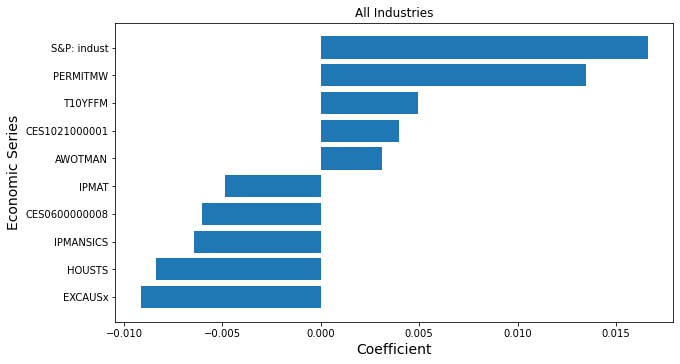

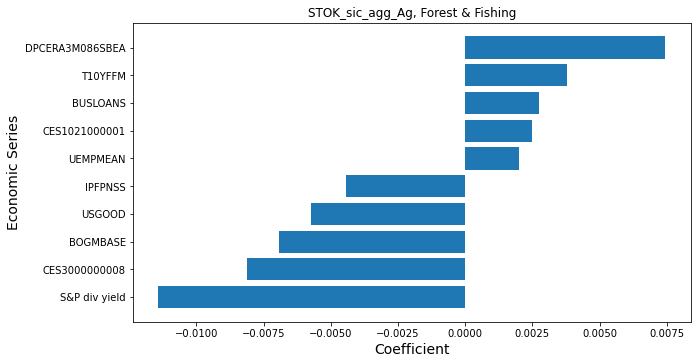

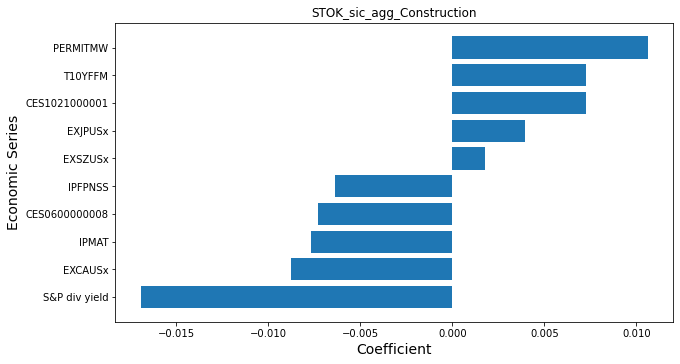

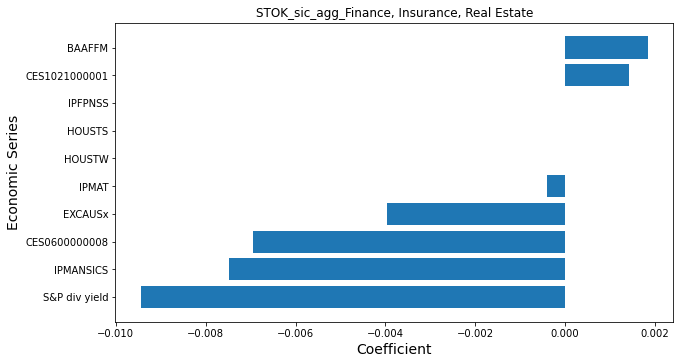

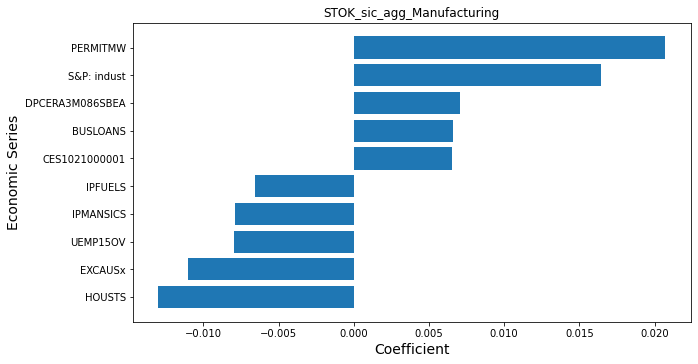

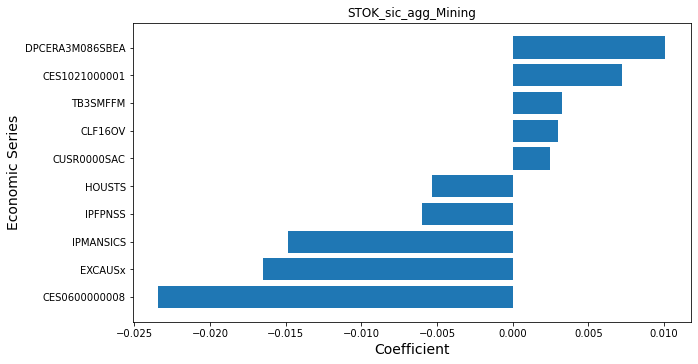

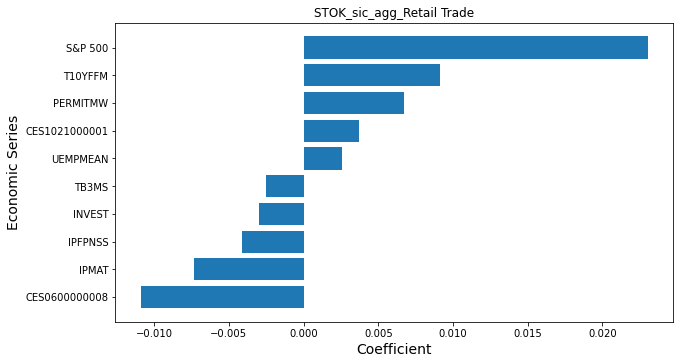

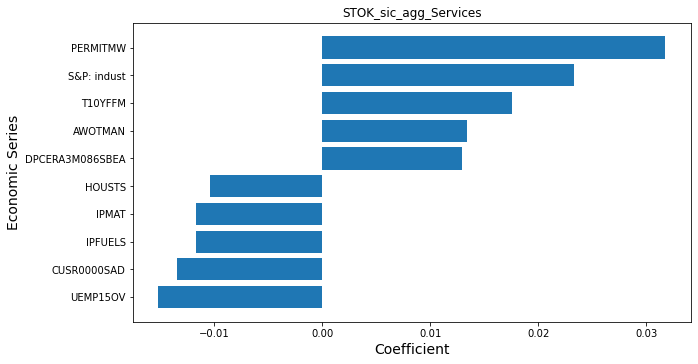

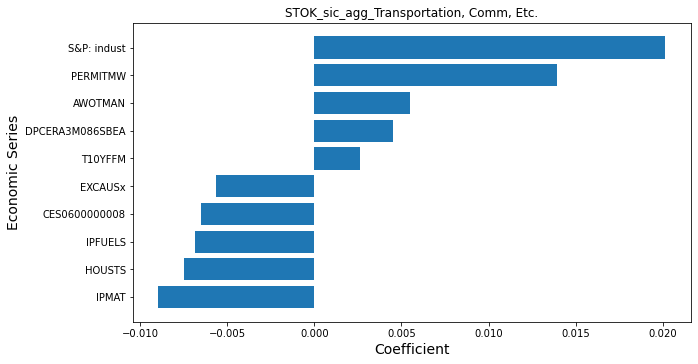

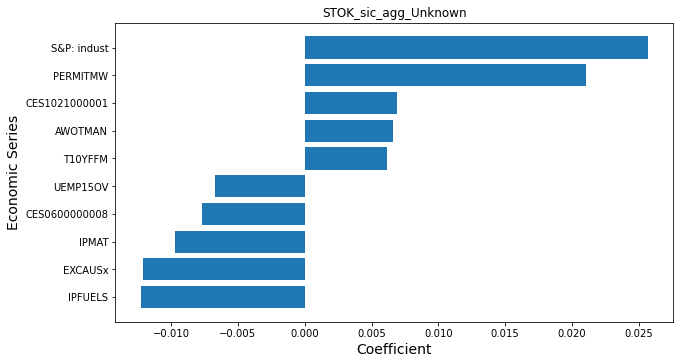

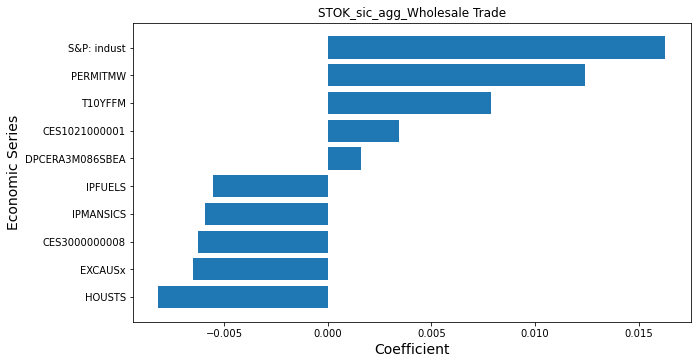

In [64]:
import matplotlib.pyplot as plt


def grapher(series, hi_lo_num):
    iter_series = series.dropna()
    iter_series = iter_series.sort_values()
    iter_series.index = [x.replace('ECON_', '') for x in iter_series.index]
    graph_series = pd.concat([iter_series.head(hi_lo_num), iter_series.tail(hi_lo_num)])
    plt.figure(figsize=(10,5.5))
    plt.title(series.name)
    plt.barh(graph_series.index, graph_series)
    plt.xlabel('Coefficient', fontsize=14)
    plt.ylabel('Economic Series', fontsize=14)
    plt.show()
    return graph_series

for col in regime_1_coeff.columns:
    grapher(regime_1_coeff[col], 5)

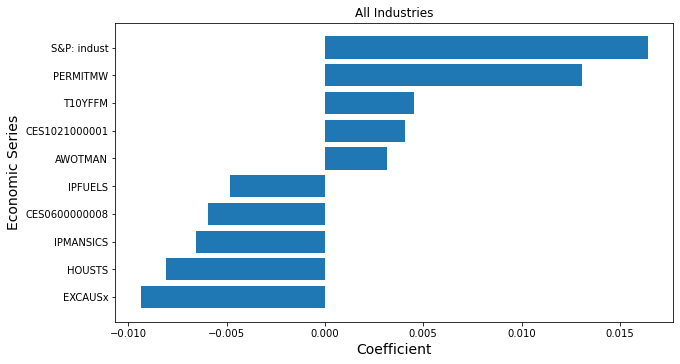

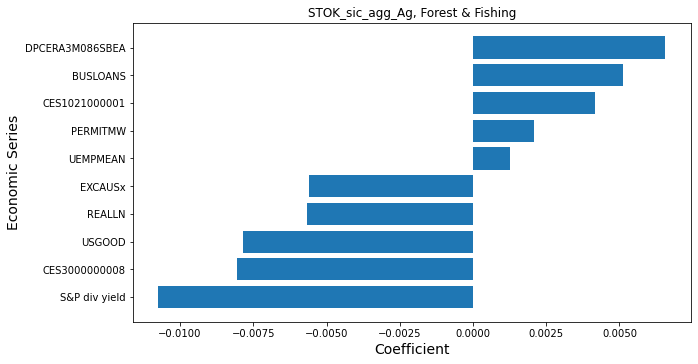

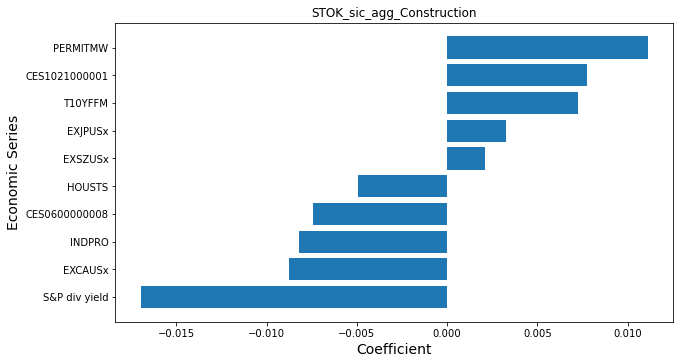

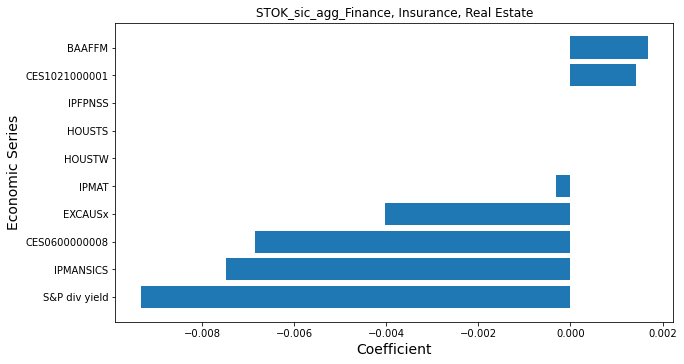

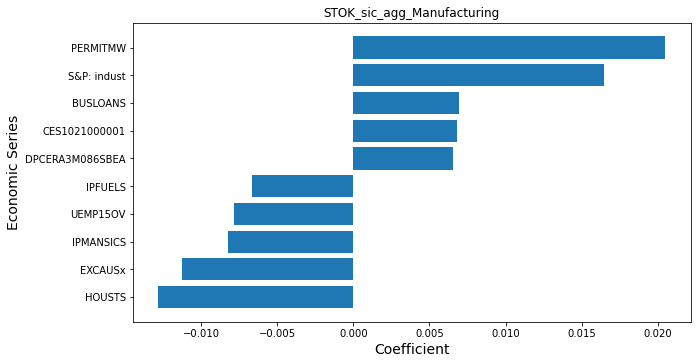

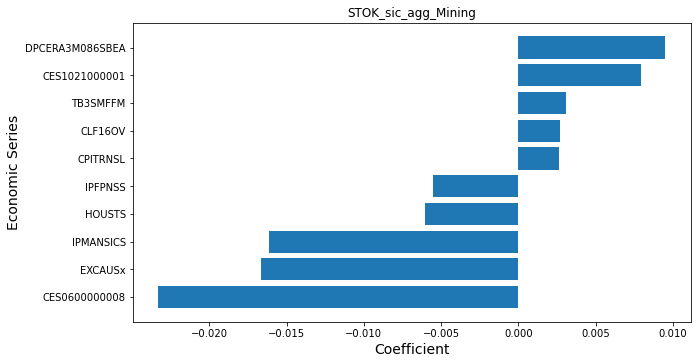

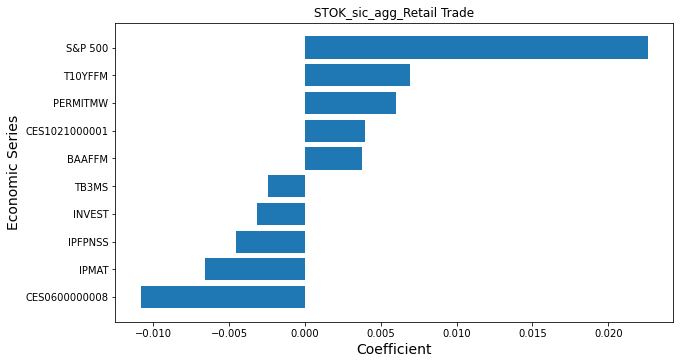

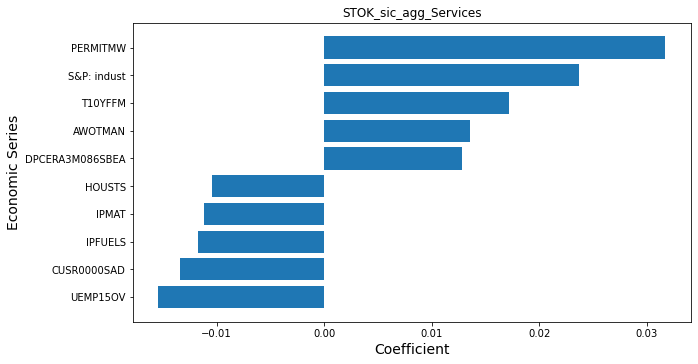

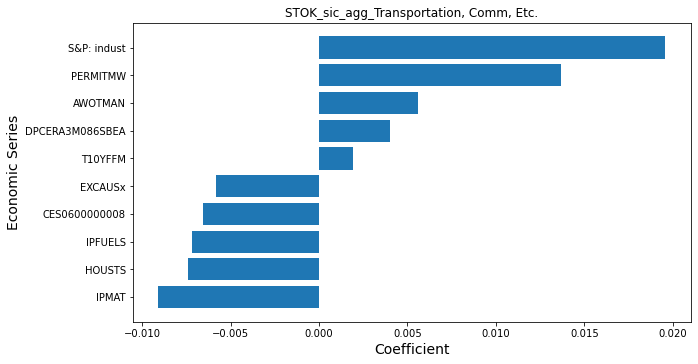

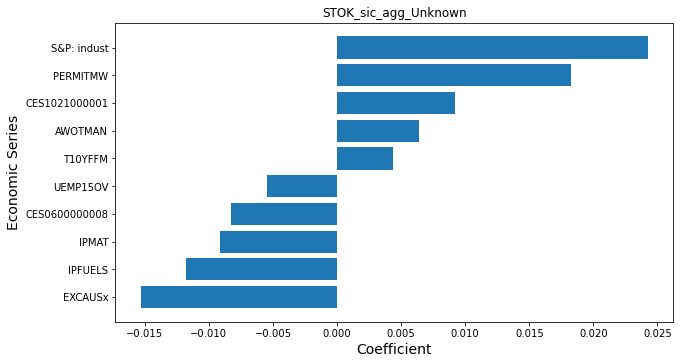

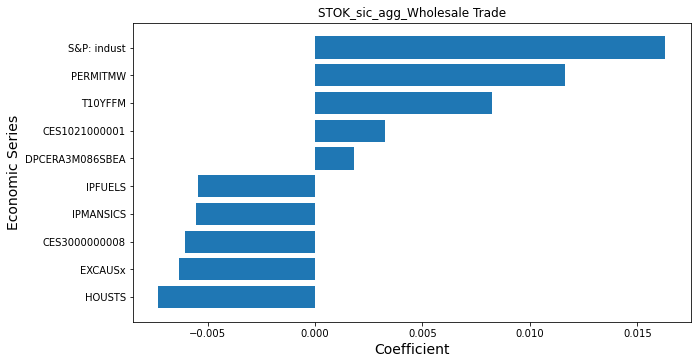

In [65]:
for col in regime_2_coeff.columns:
    grapher(regime_2_coeff[col], 5)

In [92]:
def regime_LASSO_training(trial, regim1_1_train)

    def objective_LASSO(trial, train_x = train_x, train_y = train_y, CV_x = CV_x, CV_y = CV_y, test_x = test_x, test_y = test_y):
    
    LASSO_params = {
        'alpha': trial.suggest_categorical('alpha', [.1, .075, .5, .1, .05, .025, .01, .005, .001, .0005, .0001, .000075, .00005, .00001, .000001])
    }
   
    model = Lasso(**LASSO_params)  
    model.fit(train_x,train_y)
    preds = model.predict(CV_x)
    MSE =  mean_squared_error(CV_y, np.nan_to_num(preds))
    return MSE

obj_list_ML = [objective_LASSO] #[objective_PLS, objective_LASSO, objective_RIDGE, objective_ElasticNet, objective_RF, objective_LGBM]
iter_study = optimization_instance(obj_list_ML[0], 10)

In [94]:
iter_study.best_params

{'alpha': 5e-05}

In [18]:
!pip install numba==0.53
import shap

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
import shap
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay

def perm_feat_imp(model, train_x, train_y, target, runs):
    #Setup a training sample
    perm_train = PermutationImportance(model, scoring='r2', n_iter = runs).fit(train_x, train_y)
    train_series = pd.Series(np.round(perm_train.feature_importances_, 4), index = train_x.columns)
    train_series = train_series / sum(train_series)
    return train_series #, test_series 

def shap_feat_imp(model, model_name, train_x):
    
    explainer = shap.Explainer(model.predict, train_x)
    shap_values = explainer(train_x)
    shap_values = pd.DataFrame(np.abs(shap_values.values), columns = train_x.columns).mean()
    return pd.Series(shap_values, name = model_name)

def PDP_generator(perm_df, col, top_k, style_list):
    iter_perm = perm_df['RF']
    iter_perm = pd.DataFrame(iter_perm.sort_values(ascending = False))
    top_k = list(iter_perm.iloc[0:top_k].index)
    for i in range(len(list(top_k))):
        
        standalone_features = [top_k[i]]
        
        fig = PartialDependenceDisplay.from_estimator(trained_models[1], regime_1_train_x, standalone_features).figure_
        fig.set_figwidth(6)
        fig.set_figheight(4)
        fig.tight_layout()
        plt.show()
        
        combined_features = [(top_k[i], x) for x in style_list]
        
        fig = PartialDependenceDisplay.from_estimator(trained_models[1], regime_1_train_x, combined_features).figure_
        fig.set_figwidth(len(style_list)*3)
        fig.set_figheight(6)
        fig.tight_layout()
        plt.show()
        

def importance_pipeline(X, y, target, trained_models):
            
    perm_df = pd.DataFrame(index = X.columns)
    shap_df = pd.DataFrame(index = X.columns)
    
    model_names = ['LASSO', 'RF']
    for i in range(len(trained_models)):
        
        #Calculate permutation based feature importance
        iter_perm = pd.Series(perm_feat_imp(trained_models[i], X, y, target, 1), name = model_names[i])
        perm_df = perm_df.join(iter_perm)
        
        #Calculate shapley values
        iter_shap = shap_feat_imp(trained_models[i], model_names[i], X)
        shap_df = shap_df.join(iter_shap)
        
    #Generate the PDP plots
    style_list = ['STOK_mvel1', 'STOK_beta', 'STOK_agr', 'STOK_bm', 'STOK_operprof']
    PDP_generator(perm_df, model_names[1], 5, style_list)
        
    return perm_df, shap_df




[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


Permutation explainer: 4369it [16:58,  4.26it/s]                                                                       
Permutation explainer: 4369it [2:17:33,  1.89s/it]                                                                     


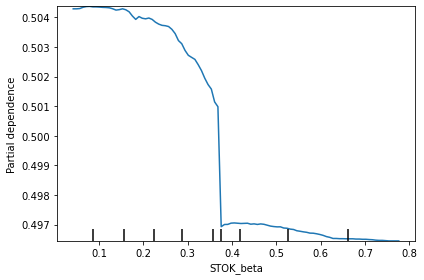

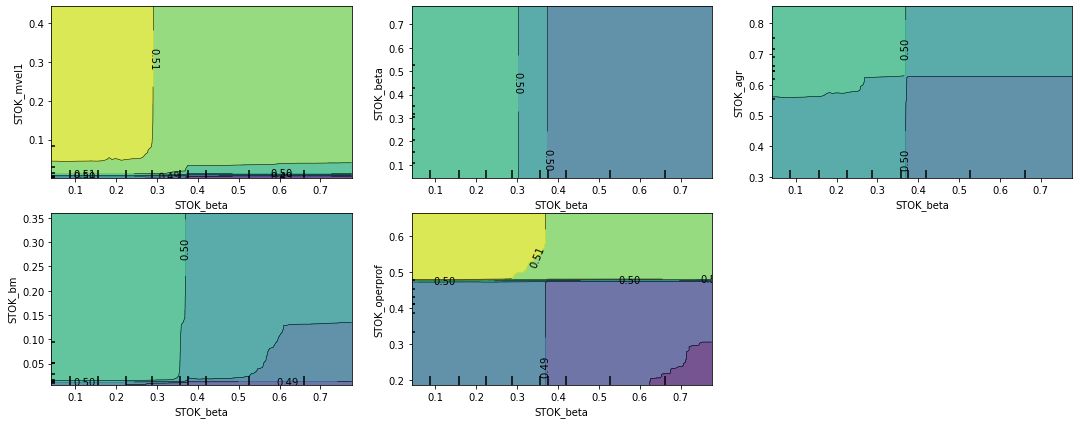

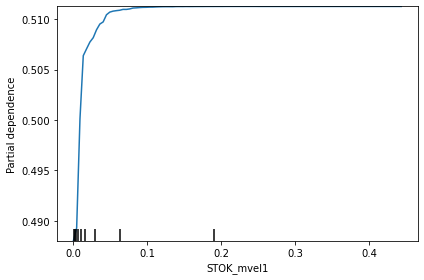

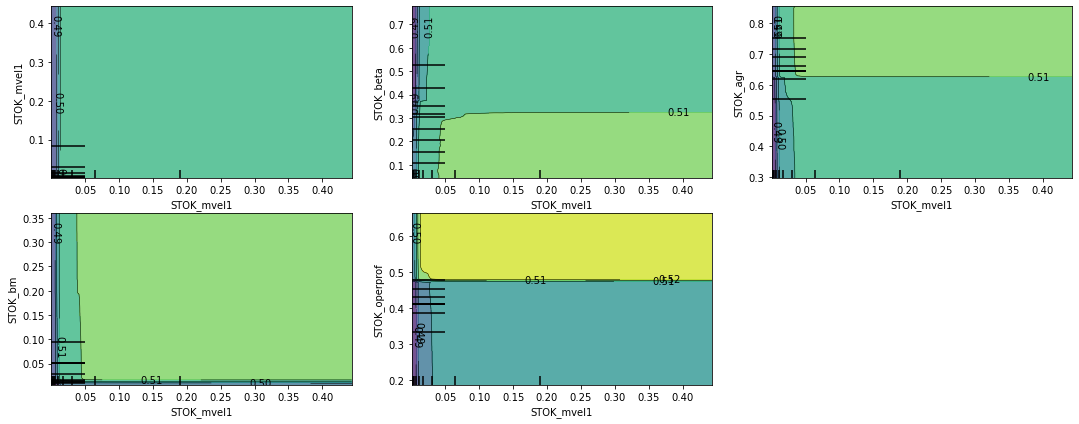

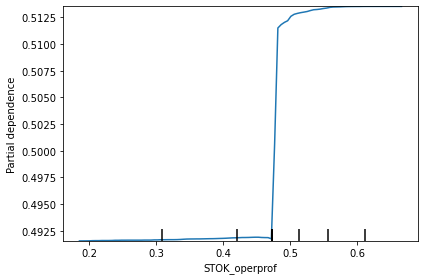

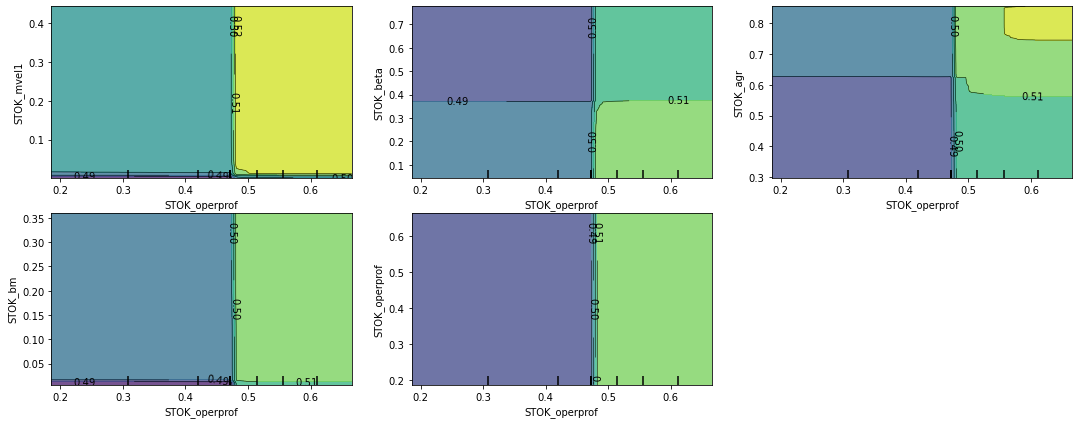

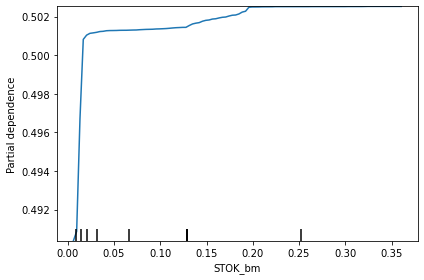

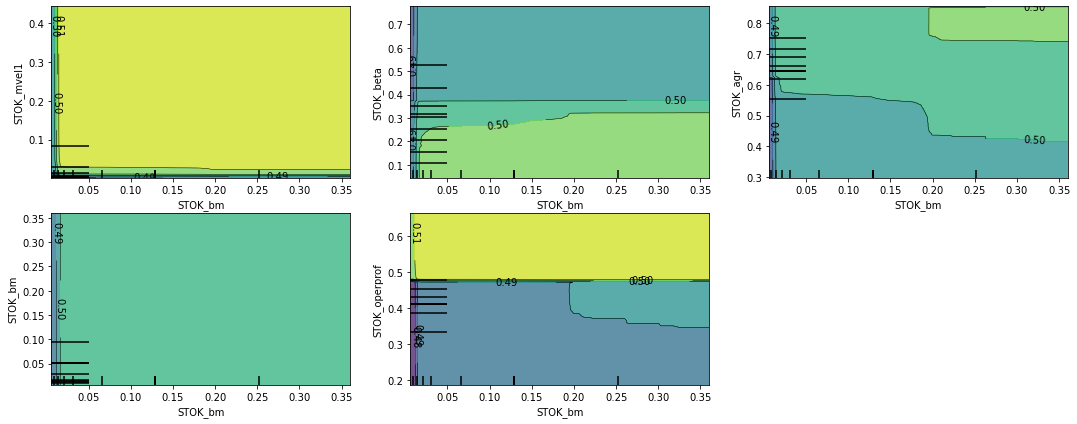

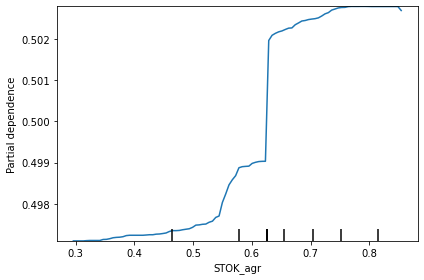

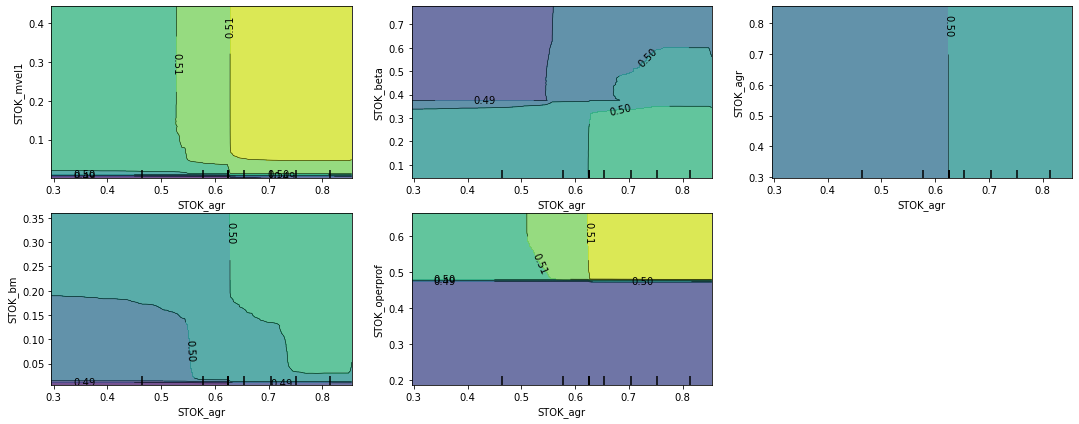

In [19]:
perm_df_regime_1, shap_df_regime_1 = importance_pipeline(regime_1_train_x, regime_1_train_y, target, trained_models)

<BarContainer object of 5 artists>

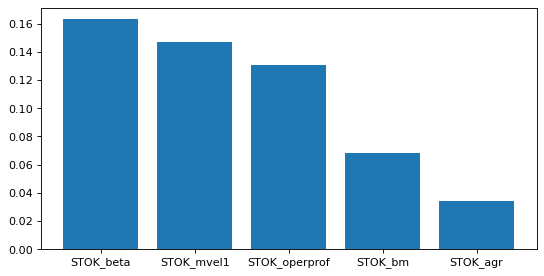

In [20]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=80)

top_5 = perm_df_regime_1['RF'].sort_values(ascending = False)[0:5]
plt.bar(top_5.index, top_5)


#shap_df_regime_1 

<BarContainer object of 5 artists>

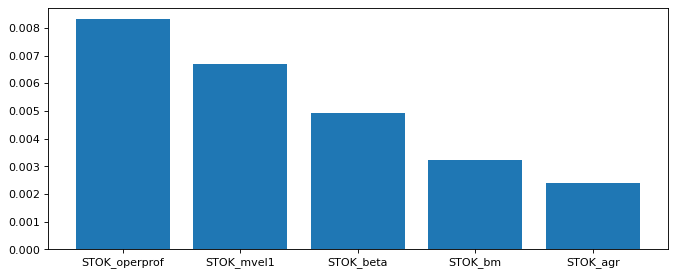

In [21]:
from matplotlib.pyplot import figure

figure(figsize=(10, 4), dpi=80)

top_5 = shap_df_regime_1['RF'].sort_values(ascending = False)[0:5]
plt.bar(top_5.index, top_5)



Permutation explainer: 5595it [21:32,  4.30it/s]                                                                       
Permutation explainer: 5595it [2:57:35,  1.91s/it]                                                                     


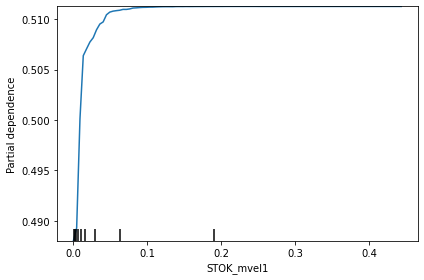

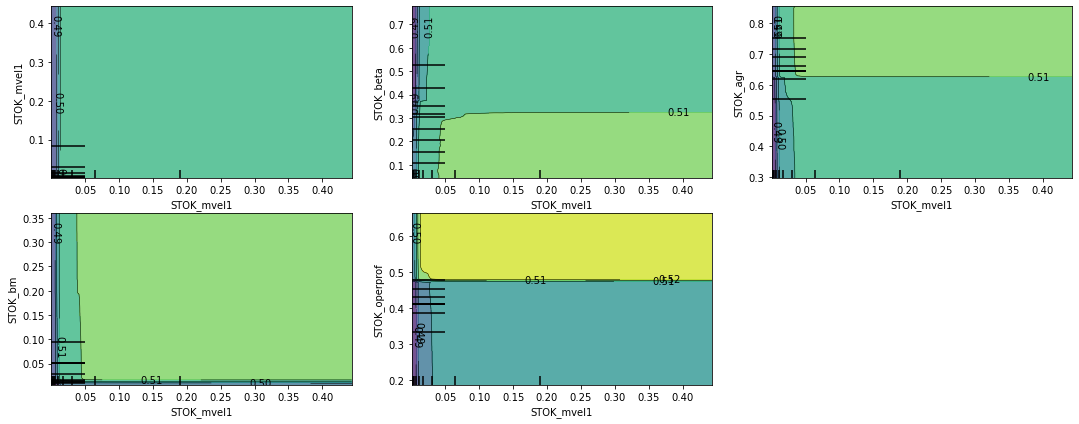

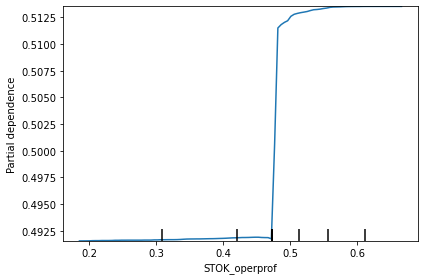

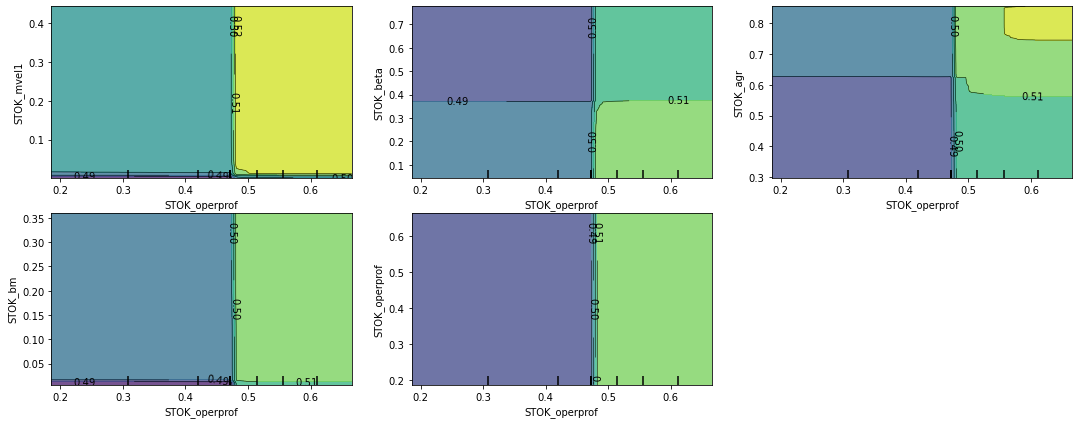

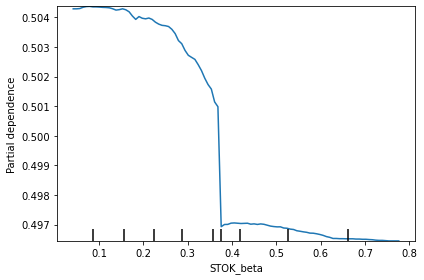

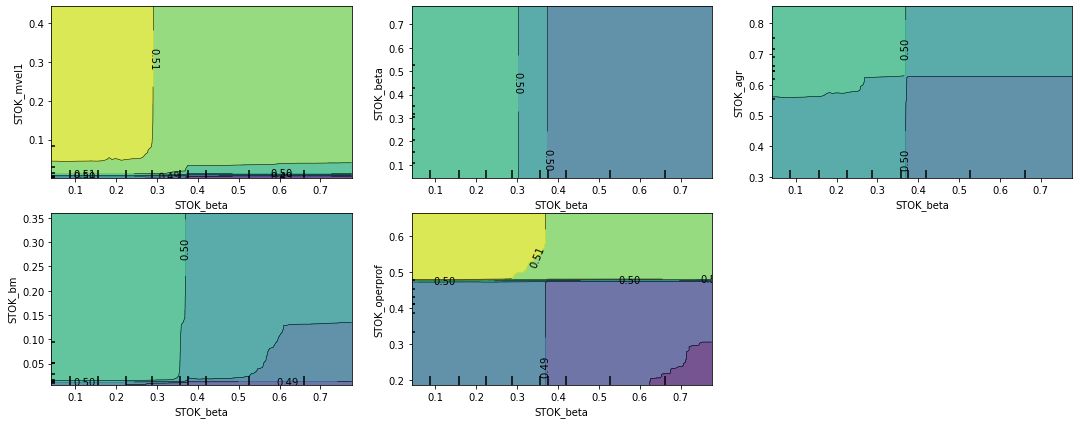

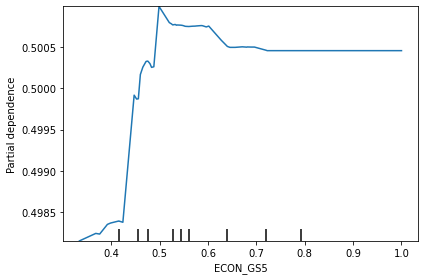

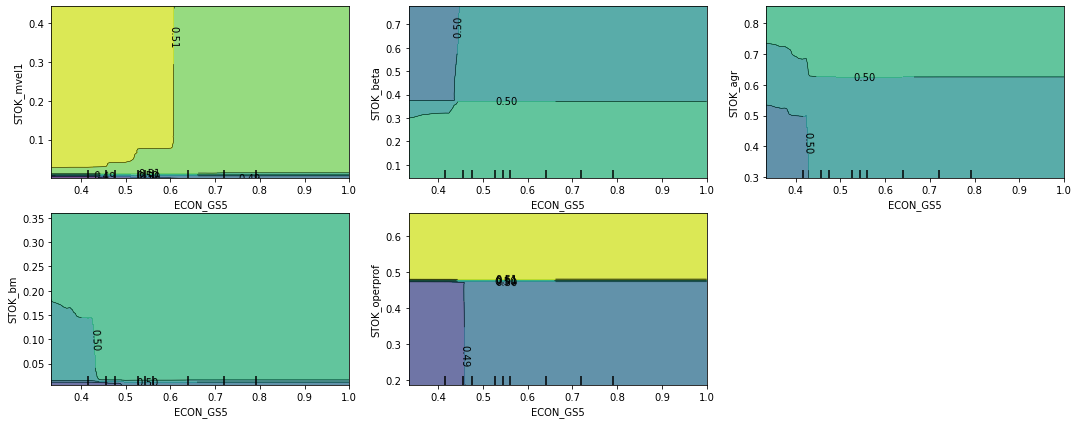

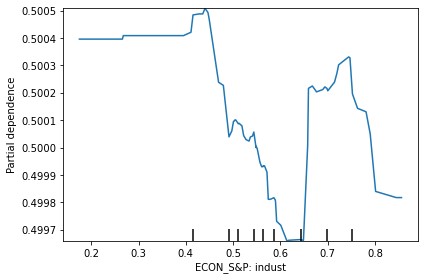

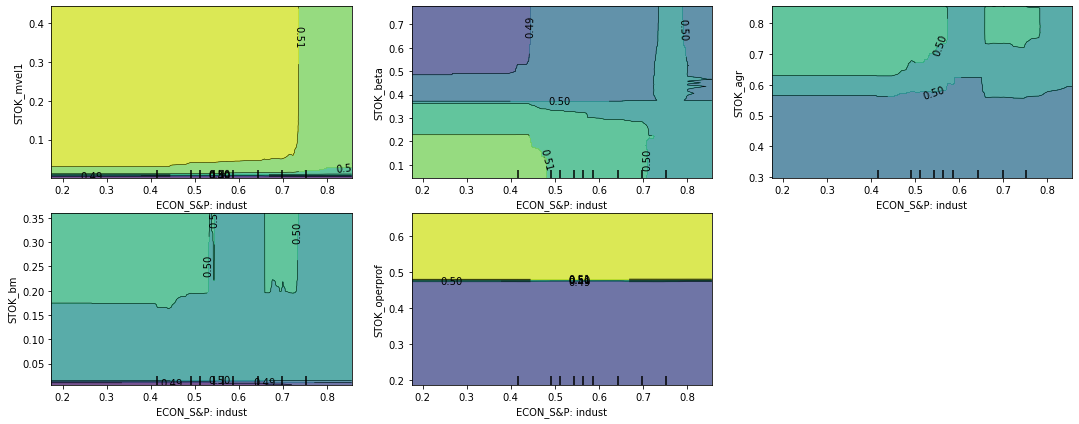

In [22]:
perm_df_regime_2, shap_df_regime_2 = importance_pipeline(regime_2_train_x, regime_2_train_y, target, trained_models)

<BarContainer object of 5 artists>

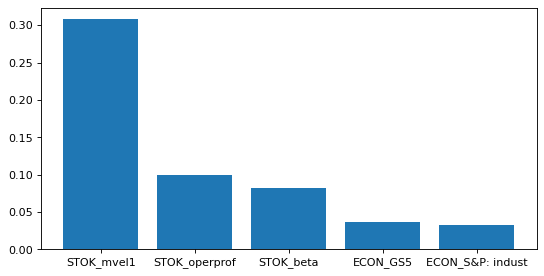

In [23]:
from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=80)

top_5 = perm_df_regime_2['RF'].sort_values(ascending = False)[0:5]
plt.bar(top_5.index, top_5)


#shap_df_regime_1 

<BarContainer object of 5 artists>

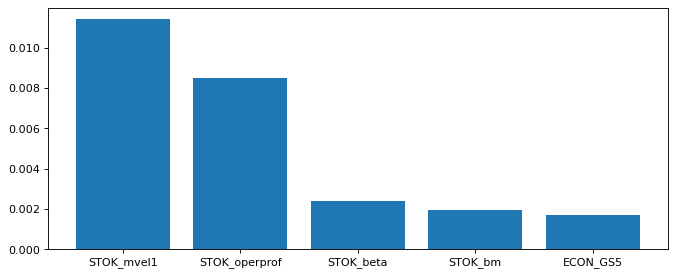

In [24]:
from matplotlib.pyplot import figure

figure(figsize=(10, 4), dpi=80)

top_5 = shap_df_regime_2['RF'].sort_values(ascending = False)[0:5]
plt.bar(top_5.index, top_5)


In [ ]:
importance_df['RF'].sort_values(ascending = True)

In [ ]:
!pip install shap


32/32 [==============================] - 0s 7ms/step


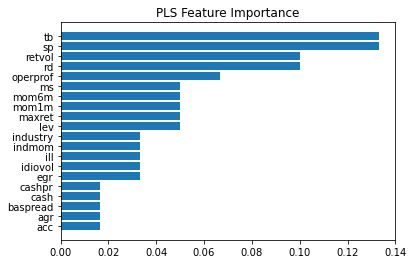

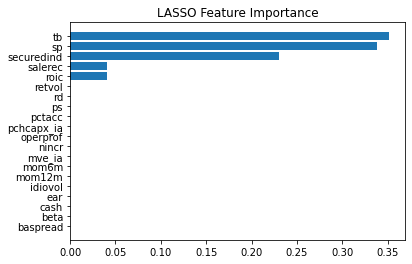

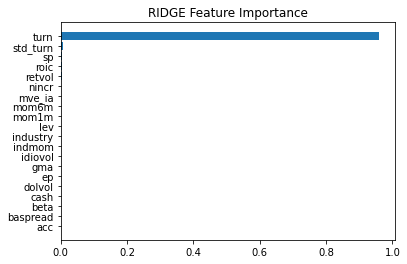

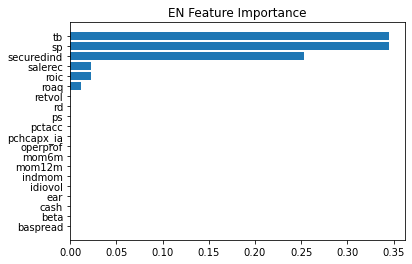

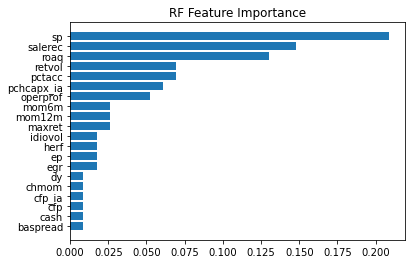

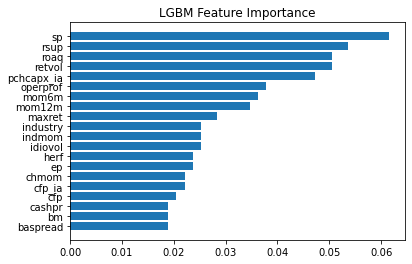

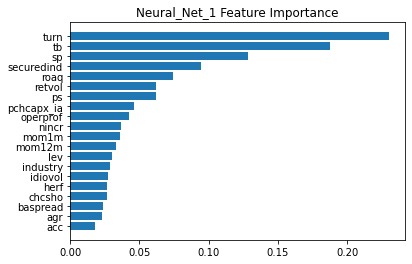

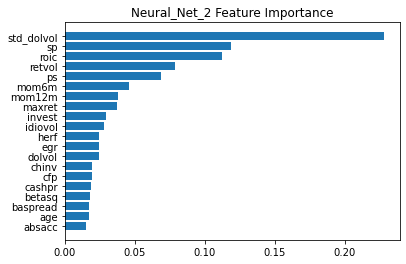

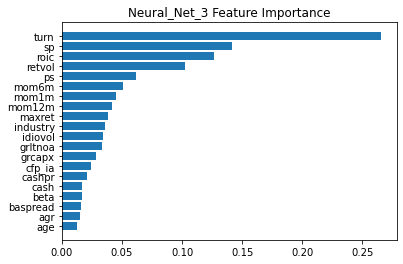

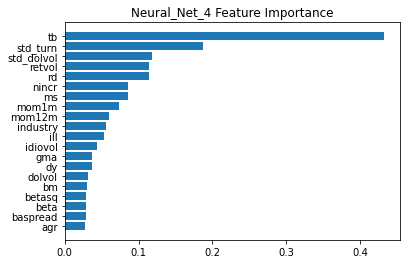

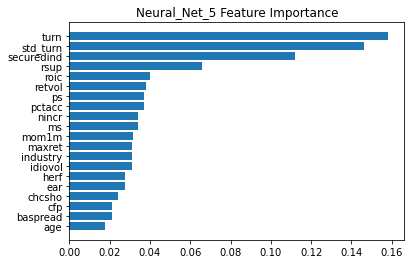

In [70]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def perm_feat_imp(model, train_x, train_y, test_x, test_y, target, runs, sample_size):
    #Setup a training sample
    train_sample = train_x.join(train_y)
    train_sample = train_sample.sample(sample_size)
    sample_train_y = train_sample[target]
    sample_train_x = train_sample.drop(target, axis = 1)
    perm_train = PermutationImportance(model, scoring='r2', n_iter = runs).fit(sample_train_x, sample_train_y)
    train_series = pd.Series(np.round(perm_train.feature_importances_, 4), index = train_x.columns)
    train_series = train_series / sum(train_series)
    return train_series #, test_series 

def perm_feat_imp_df(trained_models, train_x, train_y, test_x, test_y, target, sample_size = 5000):
    train_fi_df = pd.DataFrame(index = train_x.columns)
    base_ml = trained_models[0:6]
    #Base ML models have only one model
    model_names = ['PLS', 'LASSO', 'RIDGE', 'EN', 'RF', 'LGBM']
    for i in range(len(base_ml)):
        train_series = perm_feat_imp(base_ml[i], train_x, train_y, test_x, test_y, target, 10, sample_size = 10000)
        train_series.name = model_names[i]
        train_fi_df = train_fi_df.join(train_series)
   
    #NNs are ensembled
    NN_list = trained_models[6::]
    for i in range(len(NN_list)):
        for j in range(len(NN_list[i])):
            train_series = perm_feat_imp(NN_list[i][j], train_x, train_y, test_x, test_y, target, 1, 1000)
            train_series.name = 'NN_'+str(i)+'_v'+str(j)
            train_fi_df = train_fi_df.join(train_series)
   
    remove_cols = []
    for i in range(0, 5):
        cols = [x for x in train_fi_df.columns if 'NN_'+str(i) in x]
        train_fi_df['Neural_Net_'+str(i+1)] = train_fi_df[cols].mean(axis=1)
        remove_cols = remove_cols + cols

    train_fi_df = train_fi_df.drop(remove_cols, axis=1)
        
    return train_fi_df #, test_fi_df


train_fi_df = perm_feat_imp_df(trained_models, train_x, train_y, test_x, test_y, target, 10)

def perm_fi_plotters(bar_df):
    for col in bar_df.columns:
        sic2_idx = [x for x in bar_df[col].index if 'sic2' in x]
        iter_series = bar_df[col]
        iter_series['STOK_industry'] = iter_series[sic2_idx].sum()
        iter_series = iter_series.drop(sic2_idx)
        iter_series = iter_series.sort_values(ascending = False)     
        iter_series.index = iter_series.index.str[5::]
        plt.barh(iter_series.index[0:20].sort_values(), iter_series[0:20].sort_values())
        plt.title(str(col)+" Feature Importance")
        plt.show()
        
perm_fi_plotters(train_fi_df)

In [71]:
def surrogate_model_imp(trained_models, train_x, samples):
    sur_df = pd.DataFrame(index = train_x.columns)
    model_list = ['PLS', 'LASSO', 'RIDGE', 'EN', 'RF', 'LGBM', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']
    sample_train = train_x.sample(samples)
       
    for i in range(0, 4):
        coeff_series = pd.Series(trained_models[i].coef_.reshape(train_x.shape[1],), index = train_x.columns, name = model_list[i])
        sur_df = sur_df.join(coeff_series)
    
    for i in range(4, 6):
        y_pred = trained_models[i].predict(sample_train)
        feature_reg = Ridge(alpha=1).fit(sample_train, y_pred)
        coeff_series = pd.Series(feature_reg.coef_.reshape(train_x.shape[1],), index = train_x.columns, name = model_list[i])
        sur_df = sur_df.join(coeff_series)
        
    for i in range(6, len(trained_models)):
        for j in range(0, len(trained_models[i])):
            y_pred = trained_models[i][j].predict(sample_train)
            feature_reg = Ridge(alpha=1).fit(sample_train, y_pred)
            coeff_series = pd.Series(feature_reg.coef_.reshape(train_x.shape[1],), index = train_x.columns, name = 'NN_'+str(i-5)+'_v'+str(j))
            sur_df = sur_df.join(coeff_series)
    
    return sur_df

sur_df = surrogate_model_imp(trained_models, train_x, 10000)

313/313 [==============================] - 2s 7ms/step


In [72]:
remove_cols = []
for i in range(1, 6):
    cols = [x for x in sur_df.columns if 'NN_'+str(i) in x]
    sur_df['Neural_Net_'+str(i)] = sur_df[cols].mean(axis=1)
    remove_cols = remove_cols + cols

sur_df = sur_df.drop(remove_cols, axis=1)


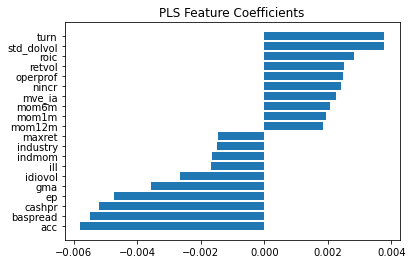

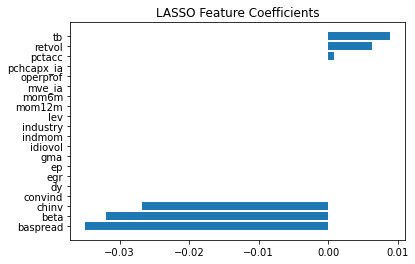

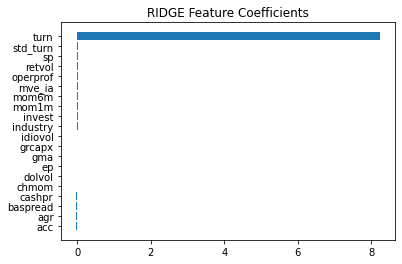

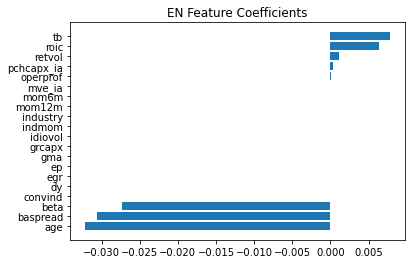

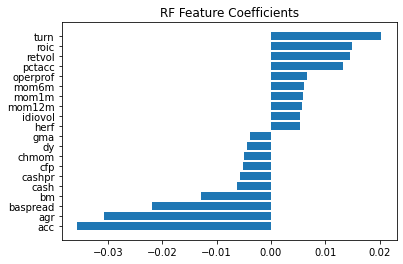

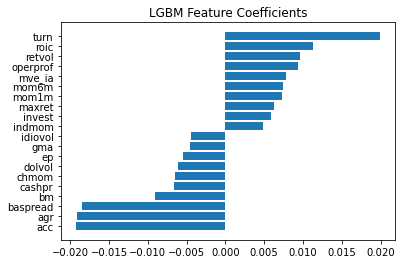

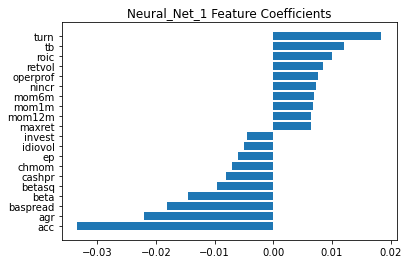

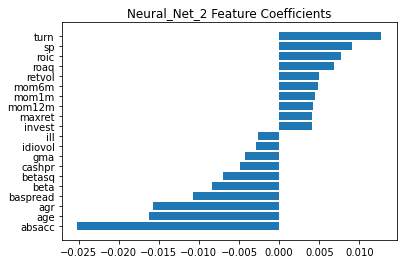

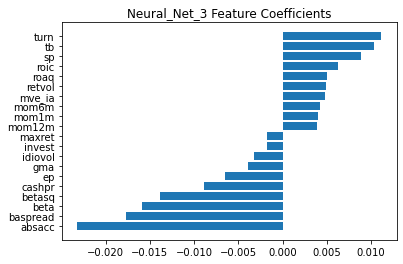

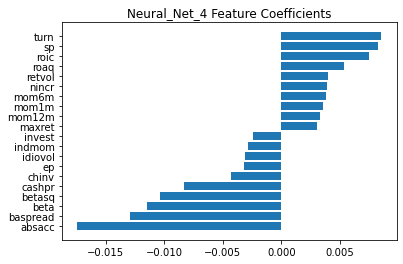

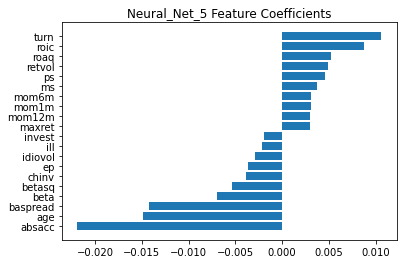

In [73]:
def coef_fi_plotters(bar_df):
    for col in bar_df.columns:
        sic2_idx = [x for x in bar_df[col].index if 'sic2' in x]
        iter_series = bar_df[col]
        iter_series['STOK_industry'] = iter_series[sic2_idx].sum()
        iter_series = iter_series.drop(sic2_idx)
        iter_series = iter_series.sort_values(ascending = False)     
        iter_series.index = iter_series.index.str[5::]
        hi_low = iter_series.tail(10).append(iter_series.head(10))
        plt.barh(hi_low.index[0:20].sort_values(), hi_low[0:20].sort_values())
        plt.title(str(col)+" Feature Coefficients")
        plt.show()
        
coef_fi_plotters(sur_df)

In [74]:
feature_path = "C:/Users/andrew_lazzeri/Desktop/Project_Files/Feature_Importance_Dfs/"
train_fi_df.to_csv(feature_path+target[0]+'_'+run_name+'_perm_feat.csv')
sur_df.to_csv(feature_path+target[0]+'_'+run_name+'_sur_feat.csv')